# Notebook A1: Structuring data without Neural Networks

**Authors:** Kenny Choo, Mark H. Fischer, Eliska Greplova

Adaptation for Summer School: ML in Quantum Physics and Chemistry (24.08.-03.09.2021, Warsaw) by Anna Dawid

In [1]:
# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Step 0. Loading and saving files with Google Colaboratory

Within these tutorials, we will need to upload some data (in particular, training data). E.g., today, we will upload Monte Carlo generated configurations of Ising spins on a 30x30 lattice. To upload data, you can pick one out of the three options (also, mix them freely):

- **Option A**. *Downloading data onto your Google drive and mounting the Google drive to this Colab notebook.*

"Mounting" means giving a temporary permission to a specific Colab notebook which enables browsing, loading, and saving files on your Google drive from this specific notebook. Once you exit the notebook, the perimission is gone, and you need to mount the Google drive again. Mounting is accompanied by an additional log-in to your Gmail account.

In [ ]:
# Option A.
# Mount your Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Option A.
# Folder where you store the data:
folder = '/content/drive/MyDrive/Colab Notebooks/ML Summer School 2021/Eliska Greplova/'

# Access the data with simple commands:
ising_training_configs = np.load(folder + "/Ising/ising_training_configs_30x30.npy")

# You can also save them there:
x = np.array([0,1])
np.save(folder + "/first_save", x)

- **Option B.** *Clone the GitHub repository*

If you want to avoid working with Google drive, you can use this work-around. All needed data are on [this GitHub](https://github.com/Shmoo137/SummerSchool2021_MLinQuantum). You can clone this GitHub repository into your Colab environment in the same way as you would in your local machine, using git clone. Once the repository is cloned, refresh the file-explorer on the left to browse through its contents.

In [ ]:
# Option B.
!git clone https://github.com/Shmoo137/SummerSchool2021_MLinQuantum

In [2]:
# Option B.
folder = "/content/SummerSchool2021_MLinQuantum/A - Phase Classification (by Eliska Greplova)/Ising_data"
# Access the data with simple commands:
ising_training_configs = np.load(folder + "/ising_training_configs_30x30.npy")

Take note these are local and temporary files, and will disappear after closing the notebook. For saving and loading data from your local machine, look at Option C.

- **Option C.** *Downloading data onto your local machine and loading/saving data onto your local computer*

For saving and loading data from your local machine, you will need 'google.colab' library.

In [ ]:
# Option C.
from google.colab import files

# Saving data on your local machine:
x = np.array([0,1])
np.save('trial', x)
files.download('trial.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Option C.
# Loading data from your local machine:
files.upload()  # it opens the file explorer where you can pick which files to upload 
                # (names stay the same as local ones)

Now we are ready to look at the data set!

# Example #1: Ising Spin Configuration Classification


The Ising model is given by the (classical) Hamiltonian:

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{<ij>} \sigma_{i}\sigma_{j},
\end{align}
where the spins $\sigma_{i} \in \lbrace -1, 1 \rbrace$ are binary variables living on the vertices of a square lattice and the sum is taken over nearest neighbours $<ij>$. 
  
At a given temperature $\beta = 1/T$, the probability of a configuration $\sigma$ is given by the Boltzmann distribution
  
\begin{align}
  P(\boldsymbol{\sigma}) = \frac{e^{-\beta H(\boldsymbol{\sigma})}}{Z},
 \end{align}
  
  where $Z$ is the partition function. This model exhibits a phase transition from the ferromagnetic phase at low tempertures to a paramagnetic phase at high temperatures. The transition temperature is $T_c \approx 2.2692$.
  
  **Task**
 
1.   Classify the ferromagnetic versus the paramagnetic phase of the Ising model
2.   Find the transition temperature
  
**Dataset**: Monte Carlo generated configurations on a 30x30 square lattice. The configuration are labelled by temperature.



## Step 1: Import data and analyze the data shape

The folder `Ising_data` contains Monte Carlo generated Ising configurations on the two-dimensional lattice. The data set is divided into training and test parts and corresponding label files containing the temperature, $T$, of each Monte Carlo sample.

In [4]:
# If you chose to clone GitHub repo:
!git clone https://github.com/Shmoo137/SummerSchool2021_MLinQuantum
folder = "/content/SummerSchool2021_MLinQuantum/A - Phase Classification (by Eliska Greplova)/Ising_data"

fatal: destination path 'SummerSchool2021_MLinQuantum' already exists and is not an empty directory.


In [3]:
N = 30 # linear dimension of the lattice 

ising_training_configs = np.load(folder + "/ising_training_configs_{0}x{0}.npy".format(N))
ising_training_labels = np.load(folder + "/ising_training_labels_{0}x{0}.npy".format(N))
ising_test_configs = np.load(folder + "/ising_test_configs_{0}x{0}.npy".format(N))
ising_test_labels = np.load(folder + "/ising_test_labels_{0}x{0}.npy".format(N))

print('train_images.shape =', ising_training_configs.shape)
print('train_labels.shape =', ising_training_labels.shape)
print('test_images.shape =', ising_test_configs.shape)
print('test_labels.shape =', ising_test_labels.shape)

train_images.shape = (1000, 30, 30)
train_labels.shape = (1000,)
test_images.shape = (1000, 30, 30)
test_labels.shape = (1000,)


We see that we have a training set of size 1000 and a test set of size 1000.

Each image is a 30x30 array which takes values in {-1, 1}. The labels of these images are the temperatures and they are in [1, 3.5]. Let us plot some data to understand it further.

In [9]:
def plot_Ising_configuration(spins, ax=None):
    '''
    this is just a helper function to plot the configuration of spins given by argument 'spins'
    '''
    if ax == None:
        print("problem")
        ax = plt.gca()
    N = 15 # np.shape(spins)[1]

    for i in range(N):
        ax.plot([i, i], [0, N-1], 'k', zorder=0, linewidth=0.5)
        ax.plot([0, N-1], [i,i], 'k', zorder=0, linewidth=0.5)

    cmap = plt.cm.Blues
    cmap2 = plt.cm.Oranges
    cmap(1)
    colors = [cmap2(140), cmap(220)] # note: orange is down, blue is up!
    colors = [cmap(220), cmap2(140)] # note: blue is down, orange is up!
    for i in range(N):
        for j in range(N):
            ax.add_patch(plt.Circle((i,j), radius=0.3, fc=colors[int((spins[i,j]+1)/2.)], zorder=2))

    ax.axes.set_axis_off()
    ax.set_ylim(-1, N+1)
    ax.set_xlim(-1, N+1)
    ax.set_aspect('equal')

In [11]:
%matplotlib inline
#import matplotlib.pyplot as plt
#import numpy as np
import seaborn as sns

# Import custom font
import matplotlib.font_manager as fm

# how to include it into github?
path = 'path_to_fonts_/fonts/Hero New Regular.otf' # for text only
#path = r'your-path\fonts\Hero New Medium.otf' # for (a), (b), etc.
custom_font = fm.FontProperties(fname=path)


In [12]:
# Import colors (e.g., as 1D and dictionary)
import pickle

# Use colors as a dictionary
infile = open('path_to_colors/colors/colors_dict.pkl','rb')
colors_dict = pickle.load(infile)
infile.close()

# Import 1D array of colors
infile = open('path_to_colors/colors/colors_1D.pkl','rb')
colors_1D = pickle.load(infile)
infile.close()

'Hero New Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


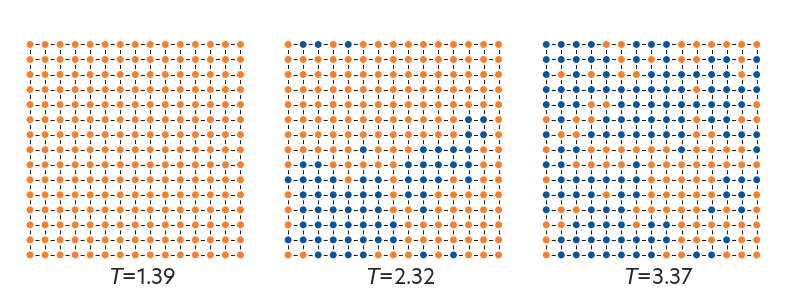

In [14]:
which_training_point1 = 150
which_training_point2 = 520
which_training_point3 = 900

sns.set(style="whitegrid", rc={'figure.figsize':(5.25,3.375)}) # in inches
sns.set_style("whitegrid", {'grid.linestyle': 'dashed', "grid.color": "0.5", 'axes.edgecolor': '.1'})

fig = plt.figure(dpi=150)
#fig.set_size_inches(10, 30)
fig.subplots_adjust(wspace=0.01,hspace=0.08, left=0.01, right=0.99, bottom=0.05, top=0.99)

ax1 = fig.add_subplot(1,3,1)
plot_Ising_configuration(ising_training_configs[which_training_point1], ax1)
ax1.set_title("$T$={:1.2f}".format(ising_training_labels[which_training_point1]), size=12, fontproperties=custom_font)
ax1.title.set_position((0.5,-0.1))

ax2 = fig.add_subplot(1,3,2)
plot_Ising_configuration(ising_training_configs[which_training_point2], ax2)
ax2.set_title("$T$={:1.2f}".format(ising_training_labels[which_training_point2]), size=12, fontproperties=custom_font)
ax2.title.set_position((0.5,-0.1))

ax3 = fig.add_subplot(1,3,3)
plot_Ising_configuration(ising_training_configs[which_training_point3], ax3)
ax3.set_title("$T$={:1.2f}".format(ising_training_labels[which_training_point3]), size=12, fontproperties=custom_font)
ax3.title.set_position((0.5,-0.1))

## Step 2: Use standard techniques to see a structure in the data
### Principal Component Analysis (PCA)

PCA is a dimensionality reduction method - it finds the features that vary the most accross the data set and then transforms the basis such that these features can be analyzed.


Here, we learn to do PCA on the above set of Ising configurations.

In [15]:
# It is worth to implement it once by yourself, step by step.
# After this one time, use libraries like sklearn or tensorflow ;)
def pca(X=np.array([]), no_dims=50):
    """
          Runs PCA on the array X (shape NxD, where D is the size of a flattened sample)
          to reduce its dimensions to no_dims (usually start with no_dims=2, so you can visualize it easily)
    """
     
    ## We need to normalize our samples, e.g., make all pixel/site values across all samples have zero mean
    # You can start by extracting the dimensions of your data, i.e., number of samples and shape of each sample
    (n, d) = X.shape

    # Calculate the mean value of each pixel/site of the configuration across all samples
    mean_sites = np.mean(X, 0)

    # Then, we substract the mean of each site over all samples, such that each site has a mean value of 0.
    print(X.shape)
    #X = X - np.tile(mean_sites, (n, 1))
    #X = X - mean_sites

    ## Now we need to create the covariance matrix out of our data set
    # Create the covariance matrix
    covariance_matrix = np.dot(X.T, X)
    print("Coviariance matrix shape:", covariance_matrix.shape)

    # Diagonalise the covariance matrix
    (l, M) = np.linalg.eig(covariance_matrix) # eigenvalues and eigenvectors
    #print("Eigenvalues: ", l)
    print("Eigenvectors shape", M.shape)

    ## Finally, we take only the first 'no_dims' columns of the eigenvector matrix 
    ## and take the inner product with the input matrix X of all configurations.
    print("First two eigenvectors shape", M[:, :no_dims].shape)
    Y = np.dot(X, M[:, :no_dims])
    print("Y shape", Y.shape)

    return Y

In [16]:
# First we reshape the data such that we are working with matrices: 
# We flatten the configurations of 30x30 into 900 vector and create matrix, X, of all 1000 configurations: 
# This has a dimension 900x1000.
print("Before reshaping:", ising_training_configs.shape)
X = np.reshape(np.array(ising_training_configs),(ising_training_configs.shape[0], 900))
print("After reshaping:", X.shape)

Before reshaping: (1000, 30, 30)
After reshaping: (1000, 900)


In [17]:
# Now we can run our PCA on 1000 flattened samples
PCA_coord = pca(X, no_dims=2)

(1000, 900)
Coviariance matrix shape: (900, 900)
Eigenvectors shape (900, 900)
First two eigenvectors shape (900, 2)
Y shape (1000, 2)


'Hero New Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


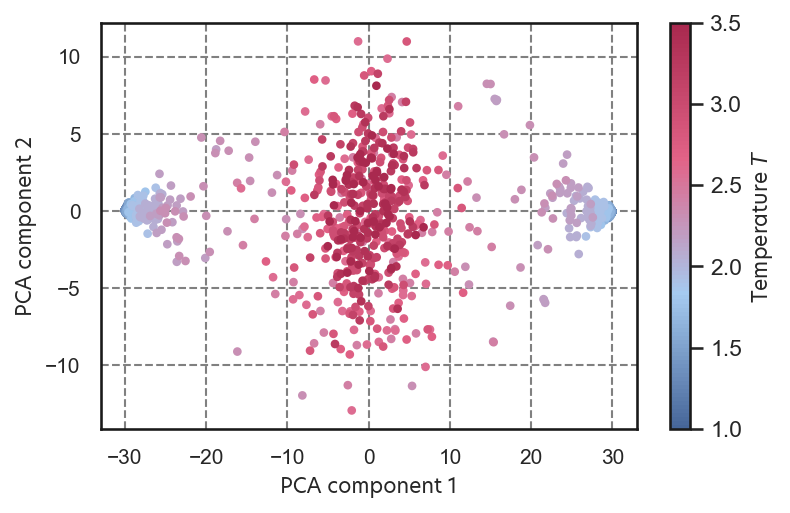

In [18]:
# Here we plot the data points in the coordinates of the first two principal components
# with the color bar created using the temperature labels

# Seaborn style set
sns.set(style="whitegrid", rc={'figure.figsize':(5.25,3.375)}) # in inches
sns.set_style("whitegrid", {'grid.linestyle': 'dashed', "grid.color": "0.5", 'axes.edgecolor': '.1'})

# colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
reverse =[(70/255, 102/255, 153/255),(166/256, 202/255, 240/255),(227/256, 99/255, 135/255),(169/255, 41/255, 79/255)]
n_bins = 100 
my_cmap = LinearSegmentedColormap.from_list('own', reverse, N=n_bins)

fig = plt.figure(dpi=150)
fig.subplots_adjust(wspace=0.01,hspace=0.01, left=0.0, right=0.9, bottom=0.15, top=0.94)
ax1 = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=10)
plt.tight_layout()

pca_plt = ax1.scatter(PCA_coord[:,0], PCA_coord[:,1], 10, ising_training_labels, 
            cmap=my_cmap)

cbar = plt.colorbar(pca_plt, )
cbar.set_label('Temperature $T$', size=12, fontproperties=custom_font)

ax1.set_xlabel('PCA component 1', size=12, fontproperties=custom_font)
ax1.set_ylabel('PCA component 2', size=12, fontproperties=custom_font)

# fig.savefig('pca_test.pdf')

The example above shows clear clusters. Thanks to the coloring the samples by the temperature that was used to generate them, we immediately see that the red, high temperature, cluster corresponds to the disordered phase and the light blue clusters on the boundaries correspond to two-types of ordered configurations: either all spins alighned up or all spins aligned down. It is possible to guess the value of the critical temperature from the color of the points placed between the clusters. Try to identify it and compare to the literature! 

# Example #2: Ising model with local constraints: Ising Gauge Theory (IGT)

In the previous example, we classified spin configurations of the simple Ising model. That was a relatively easy task given that we know that there's a global order parameter, i.e., the magnetization that distinguishes the two phases the model has.

In the following, we will look at spin configurations coming from a different model on which the simple PCA spectacularly fails. In this model, Ising spins live on the edges of a square lattice (see Figs. below). The Hamiltonian then favors even down and up spins around a square. If the number is odd, a pentalty is paid. The Hamiltonian is given by

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{p} \prod_{i \in p}\sigma_{i},
\end{align}
where we sum over the plaquettes $p$ of the square lattice.

This model does not have a finite temperature transition. We thus want to train a network to distinguish the (highly degenerate) ground states of this system from any excited state.

First, we load and analyze the shape of our data set again. As before, they are located in the folder `Ising` and labeled by a temperature.

In [19]:
N = 16 # linear dimension of the lattice 

ilgt_training_configs = np.load(folder + "/ilgt_training_configs.npy".format(N))
ilgt_training_labels = np.load(folder + "/ilgt_training_labels.npy".format(N))
ilgt_test_configs = np.load(folder + "/ilgt_test_configs.npy".format(N))
ilgt_test_labels = np.load(folder + "/ilgt_test_labels.npy".format(N))

print('train_images.shape =', ilgt_training_configs.shape)
print('train_labels.shape =', ilgt_training_labels.shape)
print('test_images.shape =', ilgt_test_configs.shape)
print('test_labels.shape =', ilgt_test_labels.shape)

train_images.shape = (2000, 16, 16, 2)
train_labels.shape = (2000,)
test_images.shape = (2000, 16, 16, 2)
test_labels.shape = (2000,)


In [34]:
def plot_igt_configuration(spins, name, dual=False, save=False):
    '''
    this is just a helper function to plot the configuration of spins given by 'spins'
    note that (i,j) denotes a vortex coordinate, such that the location of the plaquette
    center is at (i+0.5, j+0.5) and thus, the x spin is at (i+1, j+0.5) etc.

    Parameters
    ----------
    spins  :  int
        spin configuration, dimension is NxNx2
    dual   :  bool
        Plot the configuration in dual space or not. Default is False.
    '''
    N = np.shape(spins)[0]
    fig, ax = plt.subplots()
    fig.add_axes()
    ax = fig.axes[0]
    # spins = (2*spins-1)
    for i in range(N+1):
        ax.plot([i, i], [0,N], 'k')
        ax.plot([0,N], [i,i], 'k')

    if not dual:
        colors = ['#1329A4', '#F45A11'] # note: blue is down, gold is up!
        for i in range(N):
            fig.gca().add_patch(plt.Circle((0,i+0.5), radius=0.2, fc=colors[int((spins[-1,2*i]+1)/2.)]))
            fig.gca().add_patch(plt.Circle((i+0.5,0), radius=0.2, fc=colors[int((spins[i,-1]+1)/2.)]))
            for j in range(N):
                fig.gca().add_patch(plt.Circle((i+1,j+0.5), radius=0.2, fc=colors[int((spins[i,2*j+0]+1)/2.)]))
                fig.gca().add_patch(plt.Circle((i+0.5,j+1), radius=0.2, fc=colors[int((spins[i,2*j+1]+1)/2.)]))

    if dual:
        excitation = []
        for i in range(N):
            if spins[-1, 2*i+0]==1: ax.plot([-0.5, 0.5], [i+0.5, i+0.5], '#1329A4', lw=3)
            if spins[i, -1]==1: ax.plot([i+0.5, i+0.5], [-0.5, 0.5], '#1329A4', lw=3)
            for j in range(N):
                j_up = (N+j-1)%N
                i_left = (i+N-1)%N
                if spins[i,2*j+0]==1: ax.plot([i+0.5, i+1.5], [j+0.5, j+0.5], '#1329A4', lw=3)
                if spins[i,2*j+1]==1: ax.plot([i+0.5, i+0.5], [j+0.5, j+1.5], '#1329A4', lw=3)
                if spins[i,2*j+0]*spins[i_left, 2*j+0]*spins[i,2*j+1]*spins[i,2*j_up+1]==-1: excitation.append([i+0.5,j+0.5])
        if len(excitation)>0: plt.scatter(np.array(excitation)[:,0], np.array(excitation)[:,1], color='#F45A11', s=150, marker=(5,1))
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('off')
    plt.tight_layout()
    if save:
        plt.savefig("configuration_" + name +".pdf")

In [21]:
# Notice indexing: (i,j) indexes plaquettes which have centers at (i+0.5, j+0.5).
# (0,0) is the bottom left corner of the lattice!
# Then you have two spin configurations.
# First spin is one on the right side of the plaquette (i+1,j+0.5),
# Second spin is one on the upper side of the plaquette (i+0.5,j+1)
print(ilgt_training_configs[0][0,0])

[-1.  1.]


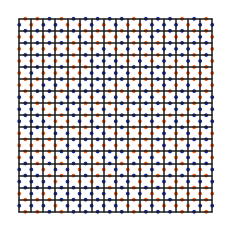

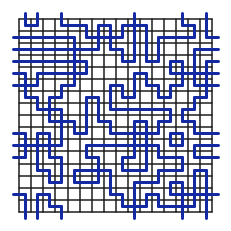

In [35]:
# Let's plot the chosen sample. But first we need to reshape the data so the plotting procedure works
N = ilgt_training_configs[0].shape[0] # size of the lattice
# Pick one sample and reshape it to flatten the two sublattices (so you have N rows of 2*N spins)
sample = 0
spins = np.reshape(ilgt_training_configs[sample],[N,2*N])

#plt configuration
plot_igt_configuration(spins,'igt0')

#plot the dual mapping
plot_igt_configuration(spins,'igt0_dual',dual=True)
#ax1.set_title("T={:1.2f}".format(ising_training_labels[250]))
#ax1.title.set_position((0.5,-0.1))

Now we repeat PCA on the IGT traing data set:

In [24]:
PCA_coord_ILGT = pca(np.reshape(ilgt_training_configs, (ilgt_training_configs.shape[0], N*N*2)), no_dims=2)

(2000, 512)
Coviariance matrix shape: (512, 512)
Eigenvectors shape (512, 512)
First two eigenvectors shape (512, 2)
Y shape (2000, 2)


'Hero New Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


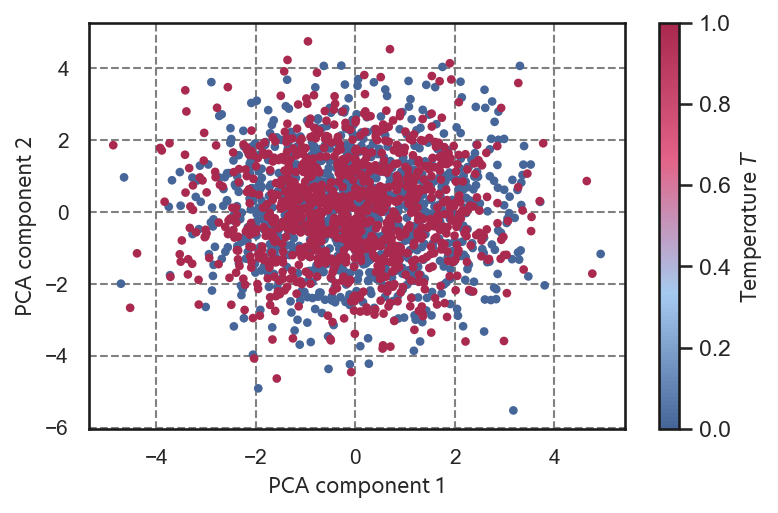

In [26]:
# Here we plot the data points in the coordinates of the first two principal components
# with the color bar created using the temperature labels

# Seaborn style set
sns.set(style="whitegrid", rc={'figure.figsize':(5.25,3.375)}) # in inches
sns.set_style("whitegrid", {'grid.linestyle': 'dashed', "grid.color": "0.5", 'axes.edgecolor': '.1'})

fig = plt.figure(dpi=150)
fig.subplots_adjust(wspace=0.01,hspace=0.01, left=0.20, right=0.9, bottom=0.15, top=0.94)
ax1 = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=10)
plt.tight_layout()

pca_plt = ax1.scatter(PCA_coord_ILGT[:,0], PCA_coord_ILGT[:,1], 10, ilgt_training_labels, 
            cmap=my_cmap)

cbar = plt.colorbar(pca_plt, )
cbar.set_label('Temperature $T$', size=12, fontproperties=custom_font)

ax1.set_xlabel('PCA component 1', size=12, fontproperties=custom_font)
ax1.set_ylabel('PCA component 2', size=12, fontproperties=custom_font)

fig.savefig('3_3_2.pdf')

Wow - by introducing a simple constraint to the Hamiltonian, we broke the PCA. It turns out that going just a little bit outside of the simple models makes straighforward clustering difficult to work. 


Extra credit assignment: you can go ahead and try more sophisticated method to test the difference between standard Ising model and IGT. One such example is t-Stochastic Neighborhood Embedding (t-SNE). Spoiler alert: it won't help you...

# t-SNE for Ising and Ising with constraints models (SOLUTION)

In [27]:
# import t-SNE method from skikit learn
from sklearn.manifold import TSNE as tsne

In [28]:
# the input should be the same as for PCA
## Ising model
#N = ising_training_configs.shape[1] #size of conf
#X = np.reshape(np.array(ising_training_configs),(ising_training_configs.shape[0], N**2))

## Ising Gauge Theory model
N = ilgt_training_configs[0].shape[0]
X = np.reshape(ilgt_training_configs, (ilgt_training_configs.shape[0], N*N*2))
# Make each pixel have zero mean

tsne_fits = tsne(n_components=2).fit_transform(X)

Text(0, 0.5, 'tSNE component 2')

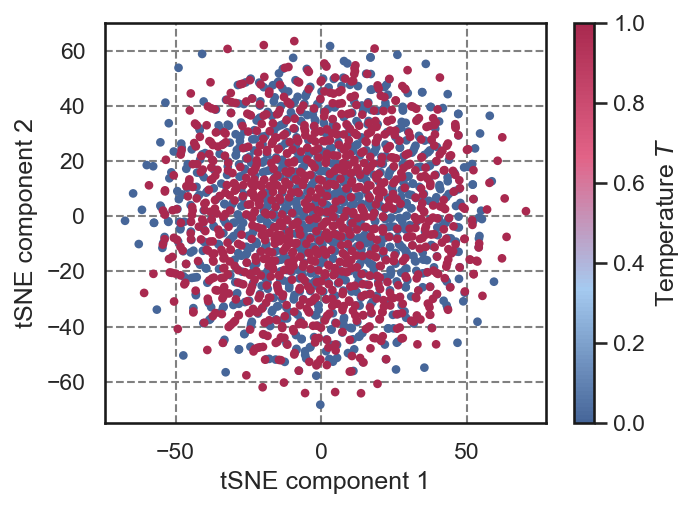

In [31]:
# Seaborn style set
sns.set(style="whitegrid", rc={'figure.figsize':(5.25,3.375)}) # in inches
sns.set_style("whitegrid", {'grid.linestyle': 'dashed', "grid.color": "0.5", 'axes.edgecolor': '.1'})

fig = plt.figure(dpi=150)
fig.subplots_adjust(wspace=0.01,hspace=0.01, left=0.20, right=0.9, bottom=0.15, top=0.94)
ax1 = fig.add_subplot(1,1,1)

# labels = ising_training_labels
labels = ilgt_training_labels
tsne_plt = ax1.scatter(tsne_fits[:,0], tsne_fits[:,1], 10, labels, 
            cmap=my_cmap)

cbar = plt.colorbar(tsne_plt, )
cbar.set_label('Temperature $T$')

ax1.set_xlabel('tSNE component 1')
ax1.set_ylabel('tSNE component 2')